# SCAM/LES Output PLotting Package
## Set up modules (standard and mine) 

In [8]:
### Import Standard Packages ###
import matplotlib.pyplot as mp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import metpy.calc as mpc
import metpy.constants as mconst
import xarray as xr
import scipy as spy
import pandas as pd
import datetime as dt
import cartopy


### To Import My Functions ###
import scam_func as mypy
import importlib


#### CONSTANTS #####
r_gas = mconst.dry_air_gas_constant.magnitude   # Specific gas constant for dry air
cp_air = mconst.dry_air_spec_heat_press.magnitude # Specific heat for dry air
Lv = mconst.water_heat_vaporization.magnitude       # Latent heat of vaporization

r_cp = r_gas/cp_air    # r/cp
grav = mconst.earth_gravity.magnitude       # Gravity ave.
p0 = mconst.pot_temp_ref_press.magnitude

#%xmode Plain   ## Fortran-like error tracebacks (doesn't seem to work though)

+++ IMPORTING MY FUNCTIONS +++


# Add Experiment Set 

In [9]:

#### SCRIPT TO READ IN SCAM OUTPUT AND MAKE SOME PLOTS ####
###### IOP file info. ######

#xr.show_versions()




## Vertical resolution ##
#scam_file_nums = ['100a','100','100b','100c']
#scam_file_nums = ['101a','101','101b','101c','101d'] # 'a'=L16, ''=L32
#scam_run_names = ['L16','L32','L64','L128','L256']

#scam_file_nums = ['102a','102','102b','102c'] # 'a'=L15, ''=L30
#scam_run_names = ['L15','L30','L60','L120']


#scam_file_nums = ['101','102'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6','CAM5']


#scam_file_nums = ['101def','102def'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 default','CAM5 default']

#scam_file_nums = ['101','101def'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 2 min','CAM6']

#scam_file_nums = ['102','102def'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM5 2 min','CAM5']

#scam_file_nums = ['101','102'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 2 min','CAM5 2 min']



#scam_file_nums = ['101d','201d','202d'] # 'a'=L16, ''=L32
#scam_run_names = ['gamma_coef=0.308','gamma_coef=0.285','gamma_coef=0.345']

### WITH LES ###

#scam_file_nums = np.array(['101d','203d','204d','LES']) # 'a'=L16, ''=L32
#scam_run_names = ['clubb_c_k10=0.5','clubb_c_k10=0.3','clubb_c_k10','LES']

#scam_file_nums = ['101a','101','101b','101c','101d']# 'a'=L16, ''=L32
#scam_run_names = ['L16','L32','L64','L128','L256']

#scam_file_nums = ['106def','106d','LES'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L32-20min','CAM6-L256-2min','NCAR']

#scam_file_nums = ['106d','106d.uv','106d.no_lsf'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L256','CAM6-L256.uv','106d.uv.no_lts']

scam_file_nums = ['106.norad','106d.norad','LES'] # ''=L16, ''=L32
scam_run_names = ['CAM6-L32-NoRad','CAM6-L256-NoRad','NCAR']

#scam_file_nums = ['106d','106d.norad','LES'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L256','CAM6-L256-NoRad','NCAR']


#scam_file_nums = ['106d','110d','112d'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L256-2min','lmin_scale = 5.','C1=0.01']

#scam_file_nums = ['106d','112d','113d'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L256-2min','C1=001','C15=0.4']

#scam_file_nums = ['106def','106d'] # ''=L16, ''=L32
#scam_run_names = ['CAM6','CAM6-L256-2min']

#scam_file_nums = ['106d','107d','108d'] # ''=L16, ''=L32
#scam_run_names = ['gamma_coef=0.308','gamma_coef=0.285','gamma_coef=0.345']

#scam_file_nums = ['106c','106c.cam5','LES'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L128','CAM5-L120','NCAR']

#scam_file_nums = ['106a','106','106b','106c','106d','LES'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L16','CAM6-L32','CAM6-L64','CAM6-L128','CAM6-L256','NCAR']



######### PRE/SUF-FIXING THE FILENAMES ##########

scam_file_pre = "FSCAM.T42_T42.SAS."
scam_file_suf = ".cam.h0.2013-06-10-39600" # most recent IC data (>=21)

#scam_file_suf = ".cam.h0.2013-06-10-43200" # Older IOP IC data (per-21)


#### LES model selections ####

les_files_in = {}
les_files_in['NCAR'] = "patton_sas_stats.nc"


########## BASE DIRS ############

dir_main = '/Users/rneale/Documents/NCAR/PBL/PBL_py_data/'




# Diagnostic Field Selections
## List of variables for each plot type

In [10]:
#### PLOTTING ####

### ### ### ### 
### 1D TS ### 
### ### ### ### 
#pvars_ts1d = np.array(['PBLH','TS','LHFLX','SHFLX','PRECC','PRECL','FLNS']) # D profile timeseries plots
#pvars_ts2d = ['DTV','VD01','DCQ','Q','T','TH','THL']
pvars_ts1d = np.array(['SHFLX','LHFLX','PBLH','PBLH_DQ'])




### ### ### ### 
### 2D TS ###
### ### ### ### 
                       ## WPSKEW is WP3_CLUBB/WP2_CLUBB**3/2
#pvars_ts2d = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT', 
#            'STEND_CLUBB','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','WP3_CLUBB','THLP2_CLUBB','WP2_CLUBB'] # 2D profile timeseries plots
#pvars_ts2d = ['WPRTP_CLUBB','Q','TH']
#pvars_ts2d = ['DTV','VD01','DCQ','Q','T','TH','THL']
pvars_ts2d = ['THV','TH','Q','WP2_CLUBB','WP3_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','RTP2_CLUBB']



### ### ### ### ### 
### 1D SNAPSHOT ###
### ### ### ### ### 

#pvars_ts2d = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT','DTCOND','DCQ']

#pvars_ts2d = ['STEND_CLUBB','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB'] 
    
#pvars_snap = ['STEND_CLUBB','RVMTEND_CLUBB','TH','THL','Q','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB']  # Snapshot plotting vars
#pvars_snap = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT','DTCOND','DCQ']
#pvars_snap = ['TH','THL','Q','RELHUM','DTV','DCQ','STEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB']
pvars_snap = ['TH','Q','WP2_CLUBB','WP3_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','RTP2_CLUBB']

tsnaps = np.array([6.,8.,10.,12.,14.,16.,18.])     # Time of snapshots (local time)

### ### ### ### ### 
### ANIMATIONS ###  # Not used yet
### ### ### ### ### 
    
pvars_anim = np.array(('Q'))

fig_file = True # Need to add this in RBN
fig_screen = True




# File and Array Setups 

In [11]:
####### DERIVED VARS #######

#scam_files_in = scam_file_pre+scam_file_nums+scam_file_suf 
scam_fig_stub=dir_main+'png/'+'_'.join(scam_file_nums)

zoffset = 6.  # Offset for Z time.


### Bundle these array for pasing to functions ###
run_info = {}
run_info['1dvars'] = pvars_ts1d
run_info['2dvars'] = pvars_ts2d
run_info['snapvars'] = pvars_snap

####### GRAPHICS ########
#mp.interactive(True)
#%matplotlib qt
#%matplotlib inline






### Construct filenames ### 

scam_files_in = np.empty_like(scam_file_nums)
scam_file_nums = np.array(scam_file_nums) 
scam_run_names = np.array(scam_run_names) 


# Standard SCAM
scam_files_in = [dir_main+'history/'+scam_file_pre+x+scam_file_suf+'.nc' for x in scam_file_nums] 

# SCAM in SAS-LES format
ii = [ix for ix, x in enumerate(scam_file_nums) if x == 'LES']# Change to LES-SAS-format file if needed 
for i in ii: scam_files_in[i] = dir_main+'history/'+scam_file_pre+scam_file_nums[0]+scam_file_suf+'_SAS_format.nc' 

# LES in SAS-LES format
scam_files_in = np.where(scam_run_names == 'NCAR', dir_main+'LES/'+les_files_in['NCAR'],scam_files_in) # Change to LES file if needed
#scam_files_in = np.where(scam_run_names == 'FAST_EDDY','LES/'+les_files_in['FAST_EDDY'],scam_files_in) # Change to LES file if needed

print(scam_files_in)

### Bundle run info ###

run_info['Run Name']   = scam_run_names
run_info['File Num']   = scam_file_nums
run_info['File Name']  = scam_files_in
run_info['zoffset']    = zoffset
run_info['Stub Figs']  = scam_fig_stub
run_info['Snap Times']  = tsnaps

#df_rinfo = pd.DataFrame(rinfo)
#df_rinfo.style.set_properties(**{'background-color': 'white','color': 'yellow'})
#df_rinfo.style.apply({'background-color': 'white'})

['/Users/rneale/Documents/NCAR/PBL/PBL_py_data/history/FSCAM.T42_T42.SAS.106.norad.cam.h0.2013-06-10-39600.nc'
 '/Users/rneale/Documents/NCAR/PBL/PBL_py_data/history/FSCAM.T42_T42.SAS.106d.norad.cam.h0.2013-06-10-39600.nc'
 '/Users/rneale/Documents/NCAR/PBL/PBL_py_data/LES/patton_sas_stats.nc']


# Plot type selection 

+++ IMPORTING MY FUNCTIONS +++
                                   long_name    units      vscale   ymin  \
LHFLX                       Latent Heat Flux     W/m2         1.0    0.0   
SHFLX                     Sensible Heat Flux     W/m2         1.0    0.0   
TS                       Surface Temperature        K         1.0  290.0   
PBLH                    Boundary Layer Depth   meters         1.0    0.0   
PBLH_DTH   Boundary Layer Depth (dth/dz max)   meters         1.0    0.0   
PBLH_DQ     Boundary Layer Depth (dq/dz max)   meters         1.0    0.0   
PBL_DQMAX          Boundary Layer dq/dz Max.  g/kg/km   1000000.0 -100.0   
PRECL              Large-Scale Precipitation   mm/day  86400000.0    0.0   
PRECC               Convective Precipitation   mm/day  86400000.0    0.0   
FLNS        Surface Net Short-wave Radiation     W/m2         1.0  200.0   
CAPE                                    CAPE     J/kg         1.0    0.0   

             ymax var_les        lscale  
LHFLX       40

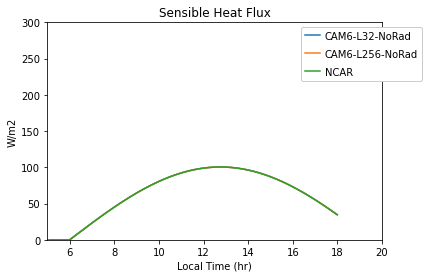

/Users/rneale/Documents/NCAR/PBL/PBL_py_data/history/FSCAM.T42_T42.SAS.106.norad.cam.h0.2013-06-10-39600.nc
--  LHFLX  ---- PLOTTING 1D TIME PLOTS ------>>>   Latent Heat Flux
106.norad  --ymin/ymax -->  0.0 375.1466979980469
/Users/rneale/Documents/NCAR/PBL/PBL_py_data/history/FSCAM.T42_T42.SAS.106d.norad.cam.h0.2013-06-10-39600.nc
--  LHFLX  ---- PLOTTING 1D TIME PLOTS ------>>>   Latent Heat Flux
106d.norad  --ymin/ymax -->  0.0 375.1466979980469
/Users/rneale/Documents/NCAR/PBL/PBL_py_data/LES/patton_sas_stats.nc
None
wqsfc


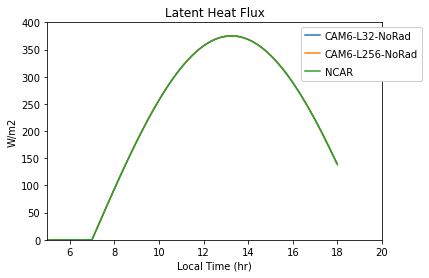

/Users/rneale/Documents/NCAR/PBL/PBL_py_data/history/FSCAM.T42_T42.SAS.106.norad.cam.h0.2013-06-10-39600.nc
--  PBLH  ---- PLOTTING 1D TIME PLOTS ------>>>   Boundary Layer Depth
106.norad  --ymin/ymax -->  296.172119140625 1857.578369140625
/Users/rneale/Documents/NCAR/PBL/PBL_py_data/history/FSCAM.T42_T42.SAS.106d.norad.cam.h0.2013-06-10-39600.nc
--  PBLH  ---- PLOTTING 1D TIME PLOTS ------>>>   Boundary Layer Depth
106d.norad  --ymin/ymax -->  266.299072265625 2050.34521484375
/Users/rneale/Documents/NCAR/PBL/PBL_py_data/LES/patton_sas_stats.nc
None
zi_t


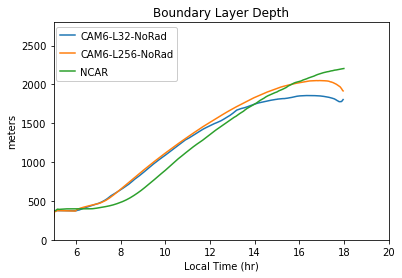

/Users/rneale/Documents/NCAR/PBL/PBL_py_data/history/FSCAM.T42_T42.SAS.106.norad.cam.h0.2013-06-10-39600.nc
<xarray.DataArray 'lev' (time: 390)>
array([ 544.053982,  544.053982,  544.053982, ..., 1237.437767, 1237.437767,
       1237.437767])
Coordinates:
    lat      float64 32.5
    lon      float64 272.8
    lev      (time) float64 544.1 544.1 544.1 ... 1.237e+03 1.237e+03 1.237e+03
  * time     (time) object 2013-06-10 11:00:00 ... 2013-06-10 23:58:00
--  PBLH_DQ  ---- PLOTTING 1D TIME PLOTS ------>>>   Boundary Layer Depth (dq/dz max)
106.norad  --ymin/ymax -->  544.0539819203466 1237.4377665036925
/Users/rneale/Documents/NCAR/PBL/PBL_py_data/history/FSCAM.T42_T42.SAS.106d.norad.cam.h0.2013-06-10-39600.nc
<xarray.DataArray 'lev' (time: 390)>
array([ 413.725097,  413.725097,  413.725097, ..., 1354.294129, 1354.294129,
       1354.294129])
Coordinates:
    lat      float64 32.5
    lon      float64 272.8
    lev      (time) float64 413.7 413.7 413.7 ... 1.354e+03 1.354e+03 1.354e+03

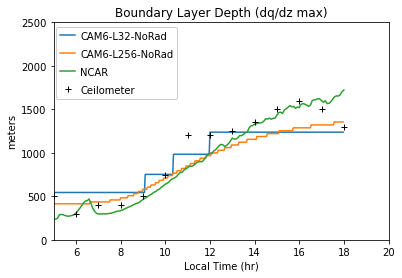


---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  THV  -  Virtual Potential Temperature  -- cmin/cmax -->  295.0 305.0
Case =  106.norad Range= 298.72820818737347 1276.780701169148
Case =  106d.norad Range= 298.7285358628901 1489.5162685610178


/Users/rneale/Documents/NCAR/python/python-scripts/PBL/scam_func.py:591: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  mp.colorbar(plt0, extend='both',cax=fig1.add_axes([0.92,  0.13, 0.02, 0.76]))


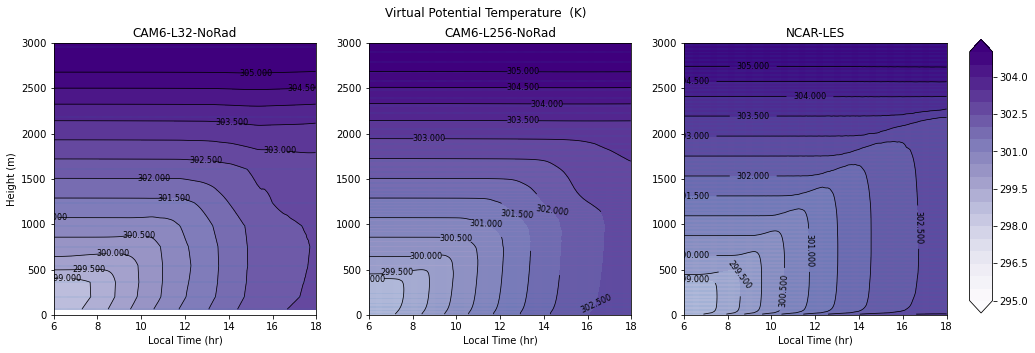


---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  TH  -  Potential Temperature  -- cmin/cmax -->  295.0 305.0
Case =  106.norad Range= 296.5928449813862 1276.77857031502
Case =  106d.norad Range= 296.59380218662085 1489.5137826667005


/Users/rneale/Documents/NCAR/python/python-scripts/PBL/scam_func.py:591: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  mp.colorbar(plt0, extend='both',cax=fig1.add_axes([0.92,  0.13, 0.02, 0.76]))


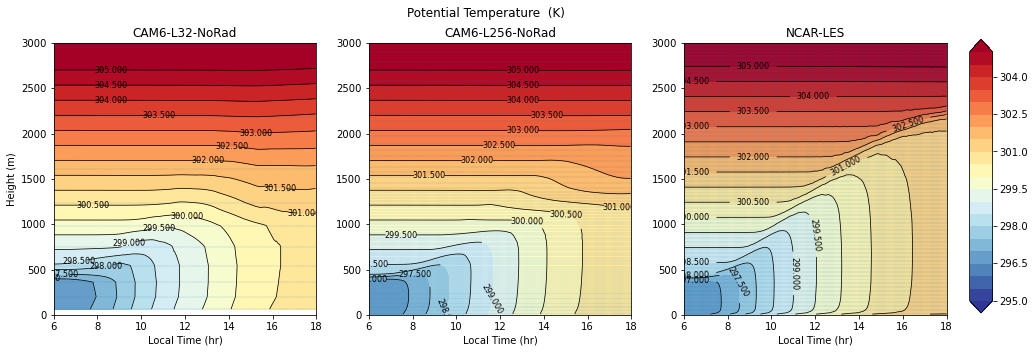


---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  Q  -  Specific humidity  -- cmin/cmax -->  1.0 12.0
Case =  106.norad Range= 5.6155296e-11 0.0118026715
Case =  106d.norad Range= 5.1746678e-08 11.799983


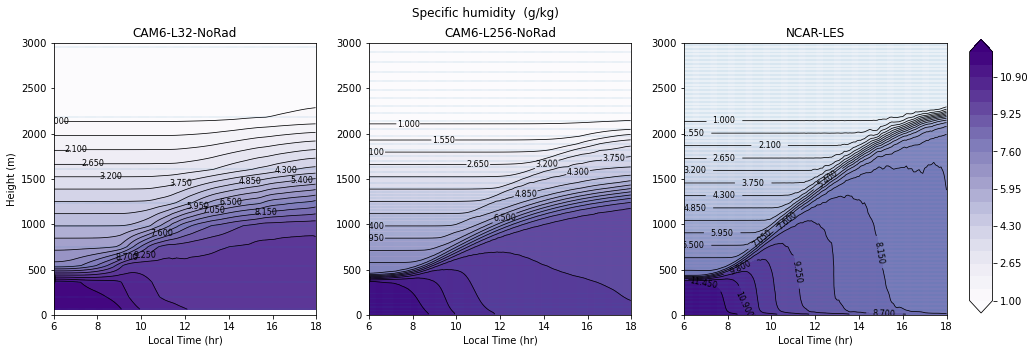


---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  WP2_CLUBB  -  Vertical Velocity Variance  -- cmin/cmax -->  0.0 2.0
Case =  106.norad Range= 0.0004 0.62713736
Case =  106d.norad Range= 0.0004 0.77523136


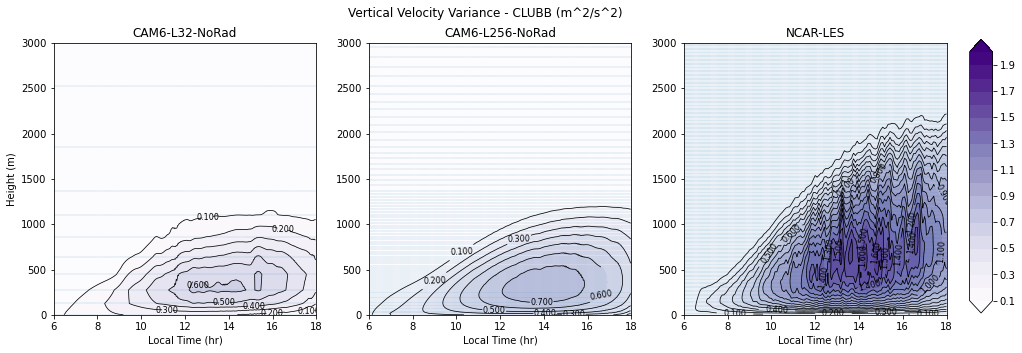


---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  WP3_CLUBB  -  Third Moment Vertical Velocity  -- cmin/cmax -->  0.0 0.5
Case =  106.norad Range= -0.0018244714 0.1286468
Case =  106d.norad Range= -0.01879344 0.12422784


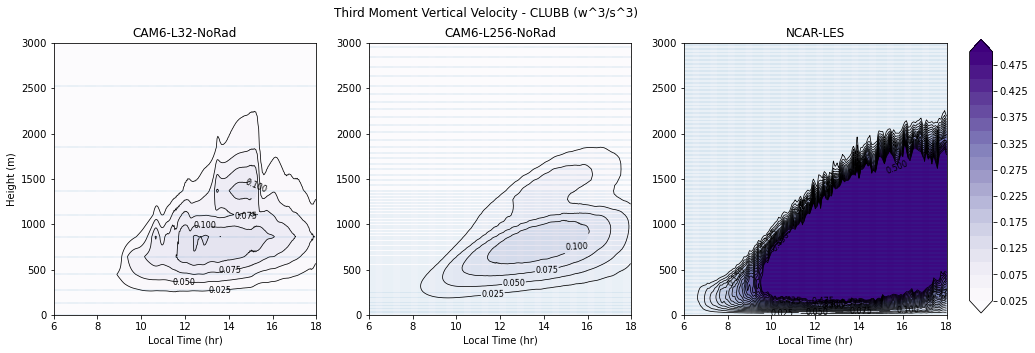


---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  WPTHLP_CLUBB  -  Heat Flux  -- cmin/cmax -->  -100.0 100.0
Case =  106.norad Range= -16.020306 101.845
Case =  106d.norad Range= -17.73765 101.17299


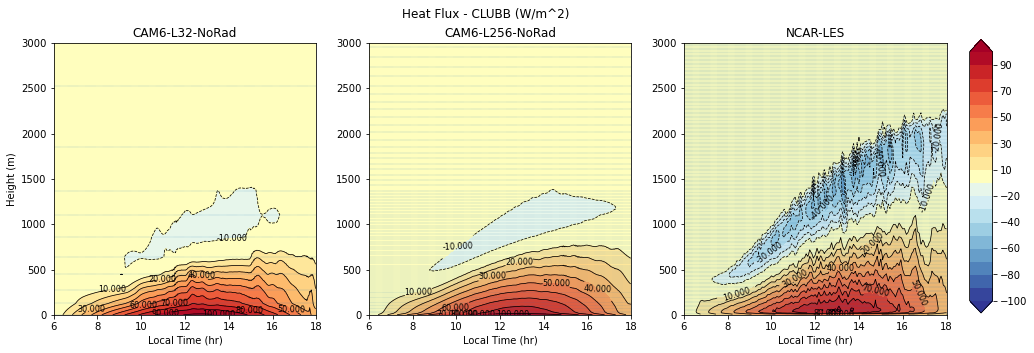


---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  WPRTP_CLUBB  -  Moisture Flux  -- cmin/cmax -->  -0.0 600.0
Case =  106.norad Range= -1.7796074 394.24268
Case =  106d.norad Range= -0.042551696 384.65756


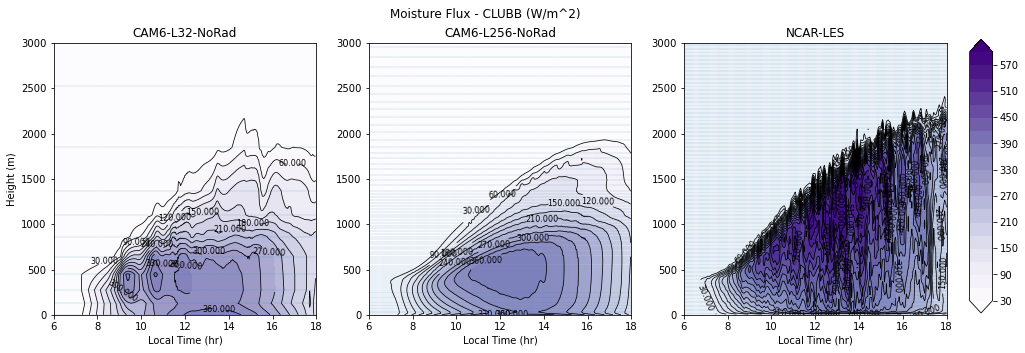


---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  THLP2_CLUBB  -  Temperature Variance  -- cmin/cmax -->  0.0 0.05
Case =  106.norad Range= 1e-04 0.0632282
Case =  106d.norad Range= 1e-04 0.03411152


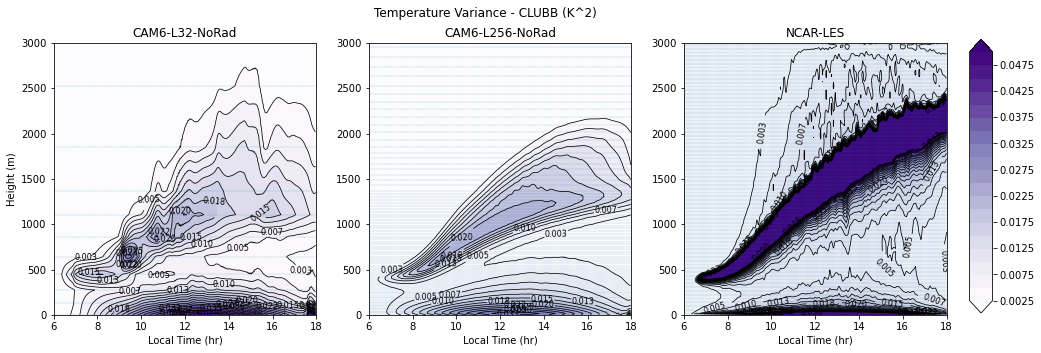


---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  RTP2_CLUBB  -  Moisture Variance  -- cmin/cmax -->  0.0 2.5
Case =  106.norad Range= 1e-10 0.6934589
Case =  106d.norad Range= 1e-10 0.5143965


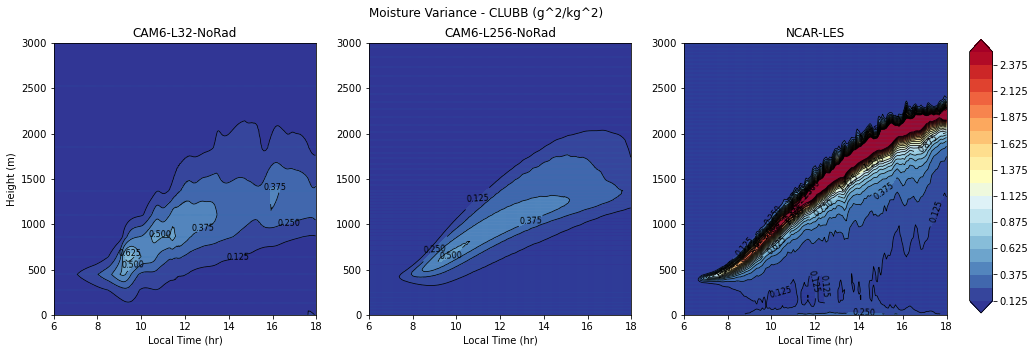

In [12]:
###### Plotting ##########
importlib.reload(mypy) # Required because I am constantly editing scam_func.py
#dir(mypy)

###### PLOTS ######

mypy.plot1d_ts_scam(run_info)   # 1D time series plots
mypy.plot2d_ts_scam(run_info)   # 2D time series plots
#mypy.plot1d_snap_scam(run_info)   # 1D snapshot plots

## New plot sets
#mypy.plot1d_mean_scam(run_info)   # 1D mean profiles
#mypy.plot1d_budget_scam(run_info)   # 1D mean profiles

#mypy.plot1d_anim_scam(run_info) # 2D profile animation plots
